# SVMguide 1

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/svmguide1(3089,4).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/svmguide1_test(4000,4).txt')
data_name = 'svmguide'
print(x_test.shape)

# x_tr = x_tr.T
x_tr = x_tr.toarray()
# x_test = x_test.T
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape
print(num, dim)
print('of objects:', num)
print('of features:', dim)
print(data_name)

(4000, 4)
3089 4
of objects: 3089
of features: 4
svmguide


## SVM
Запустим SVM для сравнения

In [3]:
from sklearn.svm import SVC

In [12]:
svm = SVC(C=10.)
svm.fit(x_tr.T, y_tr[:, 0])

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [13]:
predicted = svm.predict(x_test.T)
accuracy_score(y_test, predicted)

0.96550000000000002

## K-Means cluster centers

In [3]:
ind_num = 25
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
with open('../plots/vi_vs_svi_class/'+ data_name +'_title.txt', 'w') as f:
    title = data_name + ' dataset, ' + 'n = ' + str(num) + ', d = ' + str(dim) + ', m = ' + str(ind_num)
    f.write(title)

In [5]:
cov_params = np.array([2., 2., 1.])

## svi-L-BFGS-B-c method

In [22]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [23]:
opts = {'mode': 'full', 'maxiter': 20, 'mydisp': False}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [24]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

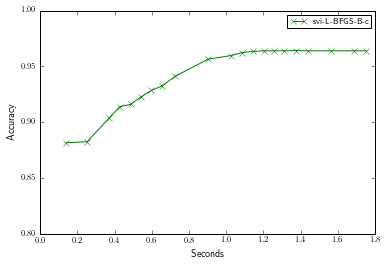

In [25]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method
Подбор числа пересчетов

In [6]:
maxfuns = [5, 10, 15, 20]
results = []
for maxfun in maxfuns:
    print(maxfun)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    vi_gp = GPC(model_covariance_obj, method='vi')
    opts = {'maxfun':maxfun, 'mydisp': False, 'num_updates':3}
    results.append(vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20))
    print()

5

10

15

20



0
1
2
3


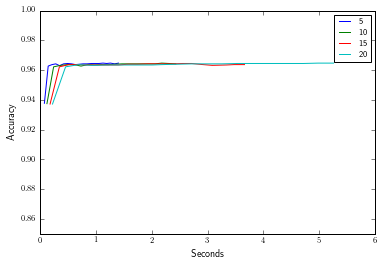

In [7]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(maxfuns)):
    vi_x_lst, vi_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(vi_x_lst[1:], vi_y_lst[1:], label=maxfuns[i])
    print(i)
plt.ylim([0.85, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

Обучение лучшего варианта

In [9]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': False, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20)

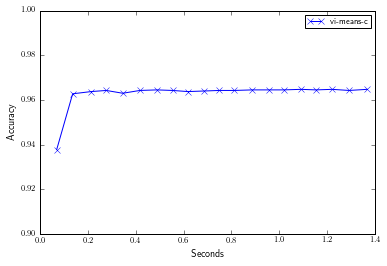

In [10]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

### Taylor
Подбор числа пересчетов

In [16]:
maxfuns = [5, 10, 15, 20]
results = []
for maxfun in maxfuns:
    print(maxfun)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    vi_gp = GPC(model_covariance_obj, method='vi')
    opts = {'bound': 'Taylor', 'maxfun':maxfun, 'mydisp': False, 'num_updates':3}
    results.append(vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20))
    print()

5

10

15

20



0
1
2
3


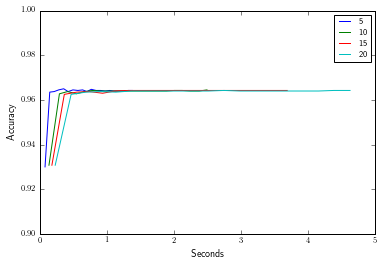

In [17]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(maxfuns)):
    temp_vi_x_lst, temp_vi_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(temp_vi_x_lst[1:], temp_vi_y_lst[1:], label=maxfuns[i])
    print(i)
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

Лучший вариант

In [19]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'bound': 'Taylor', 'maxfun':5, 'mydisp': False, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=40)

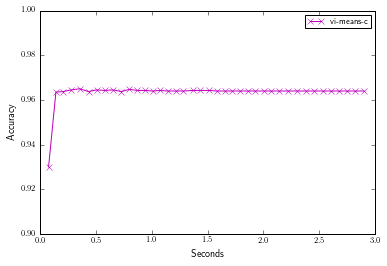

In [21]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_t_x_lst, vi_t_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

### JJ-full

In [9]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'maxiter':50, 'mydisp': False}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

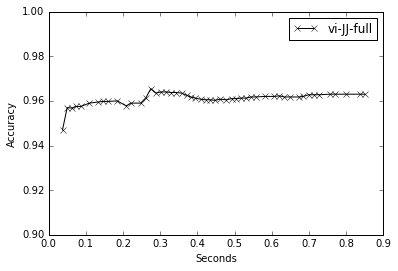

In [10]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_full_x_lst, vi_full_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подберем шаг для метода

In [14]:
results = []
steps = [1., 0.5, 0.3, 0.1, 0.01]
for step in steps:
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': False, 'batch_size': 50, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2
3
4


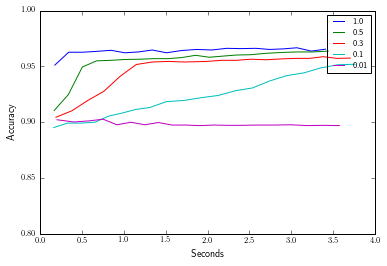

In [15]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [26]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': True, 'batch_size': 50, 
        'step_rate': 1., 'print_freq':2}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  1 :
	Gradient norm 6.24593658265
Iteration  3 :
	Gradient norm 4.16704294733
Iteration  5 :
	Gradient norm 2.79455452043
Iteration  7 :
	Gradient norm 2.23684757096
Iteration  9 :
	Gradient norm 4.30517459072
Iteration  11 :
	Gradient norm 2.27044761615
Iteration  13 :
	Gradient norm 2.30286984235
Iteration  15 :
	Gradient norm 12.491240064
Iteration  17 :
	Gradient norm 2.23275874673
Iteration  19 :
	Gradient norm 3.90466893581


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:620: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


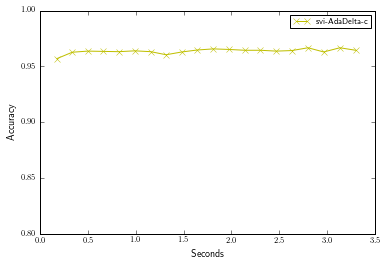

In [27]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

In [12]:
svi_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy')
svi_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy')
vi_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy')
vi_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy')
vi_t_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_x.npy')
vi_t_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_y.npy')
svi_ad_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy')
svi_ad_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy')
vi_full_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_f_x.npy')
vi_full_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_f_y.npy')

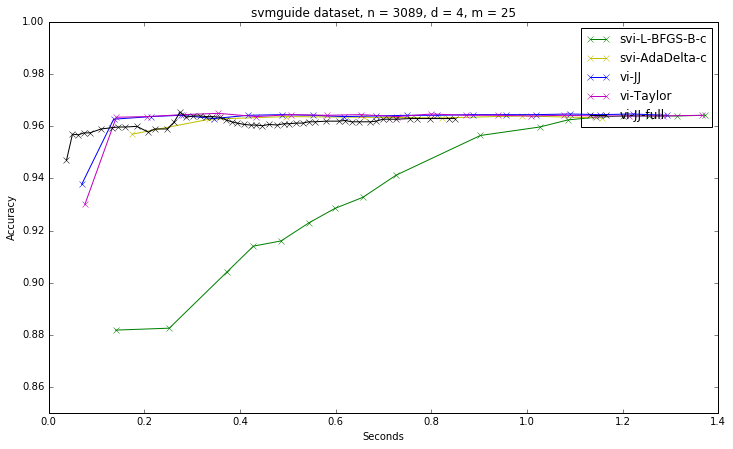

In [14]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:18], svi_y_lst[1:18], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:8], svi_ad_y_lst[1:8], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:20], vi_y_lst[1:20], '-bx', label='vi-JJ')
plt.plot(vi_t_x_lst[1:20], vi_t_y_lst[1:20], '-mx', label='vi-Taylor')
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
plt.ylim([0.85, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')
plt.title(data_name+' dataset, n = ' + str(num) + ', d = ' + str(dim) + ', m = '+ str(ind_num))

In [32]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_x.npy', vi_t_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_y.npy', vi_t_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)

In [11]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_f_x.npy', vi_full_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_f_y.npy', vi_full_y_lst)